### 32 bit persectron


METRIC          | ARITHMETIC MEAN      | HARMONIC MEAN       
------------------------------------------------------------
IPC             | 2.6387             | 2.0464            
MR              | 5.8275            % | 0.8442            %
MPKI            | 8.5990             | 0.7688            
CycWPPKI        | 230.2443           | 51.1681           

Visualization saved as 'dual_mean_results.png'


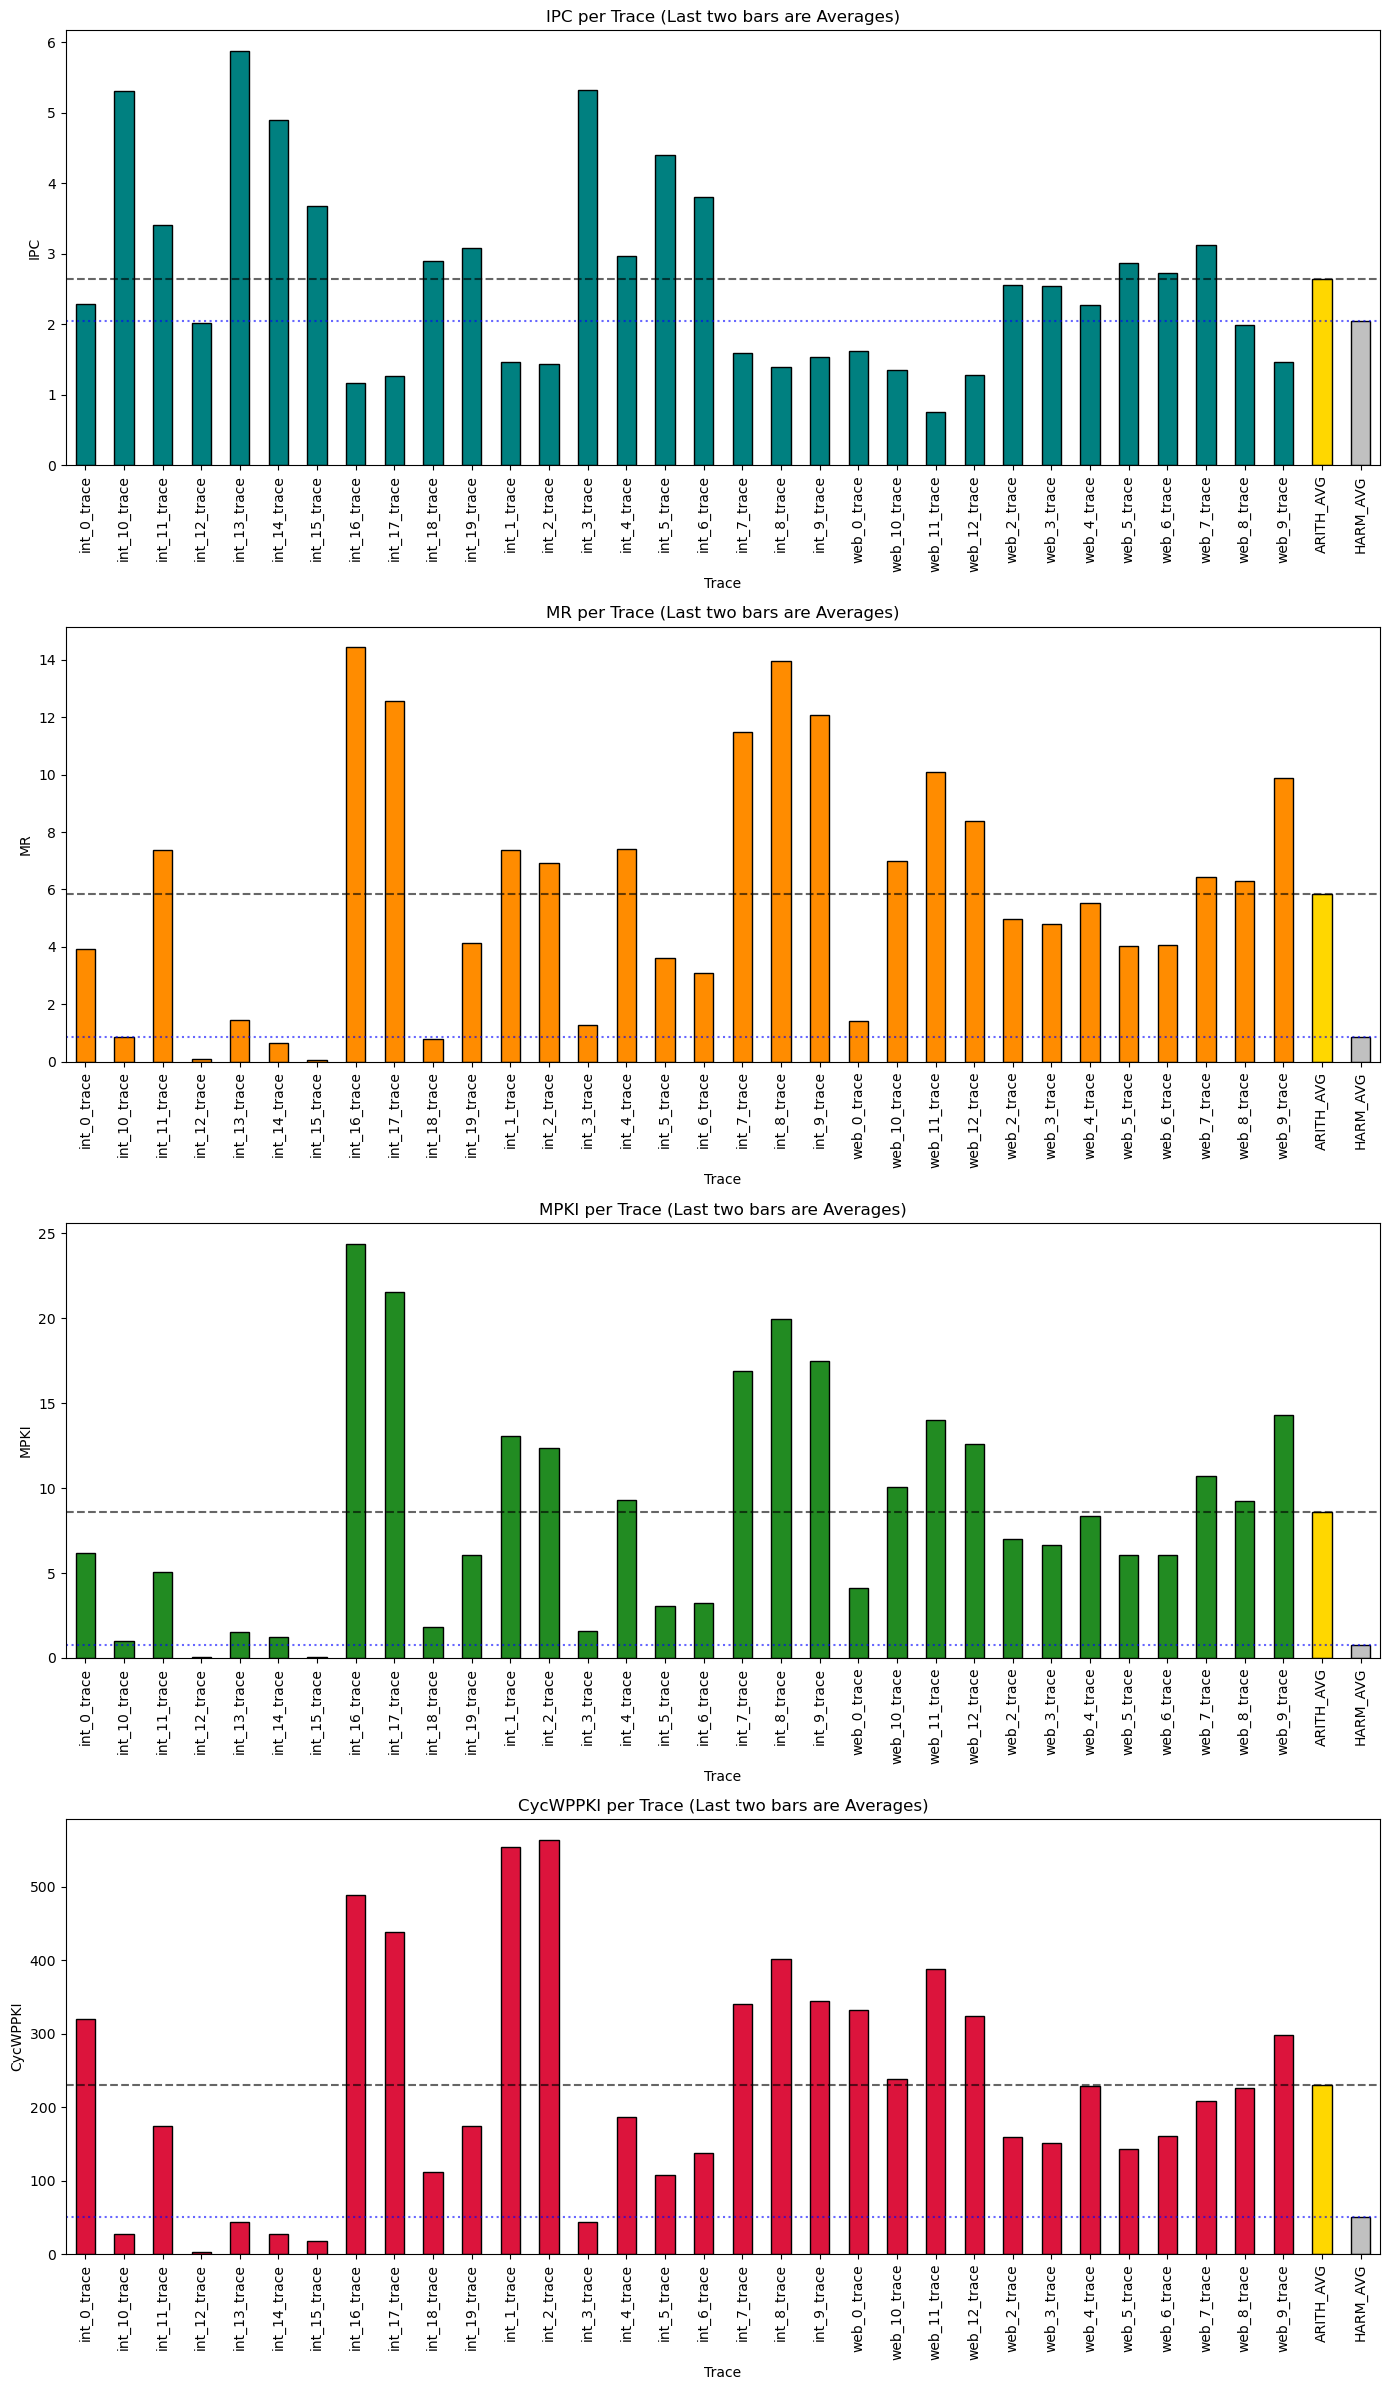

In [21]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import hmean
import numpy as np

# 1. SETUP: Path to your folder containing the 40 output files
FOLDER_PATH = '/home/vraj/Software/branch-predictor/cbp6-Branch-Predictor/results_dynamic' 

def parse_full_sim_stats(file_path):
    """Extracts IPC, MR, MPKI, and CycWPPKI from the Full Simulation table."""
    try:
        with open(file_path, 'r') as f:
            content = f.read()
        
        # This regex targets the row under the 'Full Simulation' header
        pattern = r"DIRECT CONDITIONAL BRANCH PREDICTION MEASUREMENTS \(Full Simulation.*?\n.*?IPC\s+NumBr.*?MPKI\s+CycWP\s+CycWPAvg\s+CycWPPKI\n\s+\d+\s+\d+\s+([\d\.]+)\s+\d+\s+\d+\s+[\d\.]+\s+[\d\.]+\s+([\d\.]+)%?\s+([\d\.]+)\s+\d+\s+[\d\.]+\s+([\d\.]+)"
        
        match = re.search(pattern, content, re.DOTALL)
        if match:
            return {
                'IPC': float(match.group(1)),
                'MR': float(match.group(2)),
                'MPKI': float(match.group(3)),
                'CycWPPKI': float(match.group(4))
            }
    except Exception as e:
        print(f"Error parsing {file_path}: {e}")
    return None

# 2. DATA COLLECTION
results = []
for filename in sorted(os.listdir(FOLDER_PATH)):
    if filename.endswith(".txt"):
        metrics = parse_full_sim_stats(os.path.join(FOLDER_PATH, filename))
        if metrics:
            metrics['Trace'] = filename.replace('.txt', '')
            results.append(metrics)

df = pd.DataFrame(results)

# 3. CALCULATE BOTH MEANS
metrics_cols = ['IPC', 'MR', 'MPKI', 'CycWPPKI']

# Arithmetic Mean
arith_means = df[metrics_cols].mean().to_dict()

# Harmonic Mean (Handles rates and ensures correct averaging for IPC)
# We use a lambda to handle potential zeros or NaNs safely
harm_means = df[metrics_cols].apply(lambda x: hmean(x[x > 0]) if (x > 0).any() else 0).to_dict()

# 4. PRINT SUMMARY TABLE
print("\n" + "="*60)
print(f"{'METRIC':<15} | {'ARITHMETIC MEAN':<20} | {'HARMONIC MEAN':<20}")
print("-" * 60)
for m in metrics_cols:
    suffix = "%" if m == 'MR' else ""
    print(f"{m:<15} | {arith_means[m]:<18.4f}{suffix} | {harm_means[m]:<18.4f}{suffix}")
print("="*60)

# 5. PLOTTING
fig, axes = plt.subplots(len(metrics_cols), 1, figsize=(14, 24))
colors = ['teal', 'darkorange', 'forestgreen', 'crimson']

for ax, metric, color in zip(axes, metrics_cols, colors):
    # Prepare data for plotting (Include Arith and Harm as bars at the end)
    plot_df = df[['Trace', metric]].copy()
    
    # Add Arithmetic Average row
    arith_row = pd.DataFrame({'Trace': ['ARITH_AVG'], metric: [arith_means[metric]]})
    # Add Harmonic Average row
    harm_row = pd.DataFrame({'Trace': ['HARM_AVG'], metric: [harm_means[metric]]})
    
    plot_df = pd.concat([plot_df, arith_row, harm_row], ignore_index=True)
    
    # Plotting
    plot_df.plot(kind='bar', x='Trace', y=metric, ax=ax, color=color, edgecolor='black', legend=False)
    ax.set_title(f'{metric} per Trace (Last two bars are Averages)')
    ax.set_ylabel(metric)
    
    # Add horizontal lines for visual reference
    ax.axhline(arith_means[metric], color='black', linestyle='--', label='Arith Mean', alpha=0.6)
    ax.axhline(harm_means[metric], color='blue', linestyle=':', label='Harm Mean', alpha=0.6)
    
    # Highlight the average bars specifically
    ax.patches[-2].set_facecolor('gold')   # Arithmetic bar
    ax.patches[-1].set_facecolor('silver') # Harmonic bar

plt.tight_layout()
plt.savefig('dual_mean_results.png')
print("\nVisualization saved as 'dual_mean_results.png'")
plt.show()

In [ ]:
import os
import re
import pandas as pd
import numpy as np

def harmonic_mean(data):
    return len(data) / np.sum(1.0 / np.array(data))

def extract_metrics_from_folders(root_dir):
    all_data = []
    
    # Regex to capture the values from the "Full Simulation" row
    # Groups: 1:IPC, 2:MR, 3:MPKI, 4:CycWPPKI
    pattern = re.compile(
        r"Full Simulation.*?Ends\)-+\n"  # Look for the header
        r".*?CycWPPKI\n"                # Skip the column names
        r"\s*\d+\s+\d+\s+([\d.]+)\s+\d+\s+\d+\s+[\d.]+\s+[\d.]+\s+([\d.]+)%\s+([\d.]+)\s+\d+\s+[\d.]+\s+([\d.]+)",
        re.DOTALL
    )

    for root, dirs, files in os.walk(root_dir):
        folder_name = os.path.basename(root)
        if not folder_name: continue
        
        for file in files:
            if file.endswith(".txt"):
                file_path = os.path.join(root, file)
                with open(file_path, 'r') as f:
                    content = f.read()
                    match = pattern.search(content)
                    if match:
                        all_data.append({
                            'Folder': folder_name,
                            'File': file,
                            'IPC': float(match.group(1)),
                            'MR': float(match.group(2)),
                            'MPKI': float(match.group(3)),
                            'CycWPPKI': float(match.group(4))
                        })

    if not all_data:
        return "No matching data found. Please check file paths and formatting."

    df = pd.DataFrame(all_data)
    
    # Calculate Means per Folder
    summary = df.groupby('Folder').agg({
        'IPC': ['mean', harmonic_mean],
        'MR': ['mean', harmonic_mean],
        'MPKI': ['mean', harmonic_mean],
        'CycWPPKI': ['mean', harmonic_mean]
    })
    
    # Calculate Overall Totals
    overall_arithmetic = df[['IPC', 'MR', 'MPKI', 'CycWPPKI']].mean()
    overall_harmonic = df[['IPC', 'MR', 'MPKI', 'CycWPPKI']].apply(harmonic_mean)
    
    return df, summary, overall_arithmetic, overall_harmonic

# Usage:
# df, summary, o_arith, o_harm = extract_metrics_from_folders('./Result')
print(summary)

ValueError: too many values to unpack (expected 4)